# Classification Predictions on Iris dataset

In this notebook we are going to use a well known dataset [Fisher's Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) to illustrate how `classification` problems work with `Prescience`.

## Initial Data Analysis

In [40]:
# All imports that you'll need for this notebook
import pandas
import json
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from prescience_client import prescience
from IPython.core.display import HTML

# Define the size of your figures
matplotlib.pyplot.rcParams["figure.figsize"] = (15, 10)

We previously downloaded locally the file containing data as csv, the file is located under `data/iris.csv`. You can have a look at it directly in the notebook.

Let's have a look at what is inside the first 10 rows.

In [41]:
# Local directory in which we saved the data
INPUT = 'data/iris.csv'
# Our local data is a CSV and has a header row
HAS_HEADER = True

# Read the csv data and get a pandas.Dataframe
INITIAL_DATAFRAME = pandas.read_csv(INPUT)

# Display the first 10 lines of the data into HTML
HTML(INITIAL_DATAFRAME.head(10).to_html())

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


We can see that the initial data is composed of 5 columns :
* `sepal_length` : The length of the sepal
* `sepal_width` : The width of the sepal
* `petal_length` : The length of the petal
* `petal_width` : The width of the sepal
* `label` : The category (class) of the iris

The first 4 properties are components of each iris flower : the `sepal` and the `petal` measured by their characteristics `width` and `length`.

The last property is the sub-category of each iris between 3 : `Iris-setosa`, `Iris-versicolor`, `Iris-virginica`

## Upload on Prescience and parse the data

Now that we had a first look locally on our data, let's upload it on prescience.

When we upload data on prescience, it automatically starts a `parse task`. A `parse task` is responsible for doing some pre-analysis on your data by creating a `source` object. You can choose the name that you want to give to your source, it is known as the `source_id`.

### Name your source object

In [42]:
# Name that you want to give to your source object
SOURCE_ID = 'iris'

### Launch the parse task

You can lanch a `parse task` directly in your python code :

In [43]:
# We create a local file input from our csv file
csv_input = prescience.csv_local_file_input(INPUT, headers=HAS_HEADER)

# We start a parse task on prescience and watch for it (i.e we wait until the task ends)
parse_task = csv_input.parse(source_id=SOURCE_ID).watch()

Uploading source with following arguments :
{
    "source_id": "iris",
    "type": "CSV",
    "headers": true,
    "separator": "COMMA"
}
Task parse 97af1ec1-68f5-4e2e-98a1-7b6f42fca89e DONE


#### Terminal equivalent command :

`prescience start parse data/iris.csv --input-type CSV --source-id iris --watch`

### Show the result of the parse task

Once the parse task is over, you can look at what prescience found as schema for your `source` object.

In [44]:
# We get back the created source from the finished task
source = parse_task.source()

# We display the computed sources statistics of the schema
source.schema().show('html')

,name,type,nullable,n_cat,ratio,n_pop,median,mode,positive
0,sepal_length,double,True,0,None,None,5.8,None,True
1,sepal_width,double,True,0,None,None,3.0,None,True
2,petal_length,double,True,0,None,None,4.3,None,True
3,petal_width,double,True,0,None,None,1.3,None,True
4,label,string,True,3,None,None,0.0,Iris-virginica,True


As you can see in the previous table, the `parse` task correctly find the schema of your data as well as some statistics about it.

#### Terminal equivalent command :

`prescience get source iris --schema`

### Retrieve all your parsed sources in your project
At any time you can retrieve all the `sources` your parsed inside your project

In [45]:
# Display the list of all sources in your prescience project
prescience.sources().show('html')

,source_id,status,input_type,info
0,iris,BUILT,CSV,None


#### Terminal equivalent command :

`prescience get sources`

### Retrieve your source by its ID
At any time you can retrieve any of your parsed `source` by its ID

In [46]:
# Display the list of all sources in your prescience project
source = prescience.source(SOURCE_ID)

#### Terminal equivalent command :

`prescience get source iris -o json`

## Problem Definition

Now we want to be able to make predictions based on this time-series and we want to let prescience infer the predictive model for us. For that purpose, we are going to start an `auto-ml task` after defining problem's metadata.

### The problem type

It is the problem that we want to solve. In this case it's a `classification`.

In [47]:
PROBLEM_TYPE = 'classification'

### The label column
It the the column that you want to predict. In our case, it is the `label` column.

In [48]:
LABEL_COLUMN = 'label'

### The scoring metric
It is the metric that we want to use to evaluate the relevance of trained models. In case of `classification` the `accuracy` is a good metric.

In [49]:
SCORING_METRIC = 'accuracy'

## Start the Automated Machine Learning Task
With all the previous information we can start the auto-ml task and wait for it to complete (This can take some times). We will see later that this task creates 2 objects : a `dataset` and a `model` that's why the functions returns a task and 2 identifiers.

In [50]:
# Start an AUTO-ML task
task, dataset_id, model_id = source.start_auto_ml(
    label_id=LABEL_COLUMN,
    problem_type=PROBLEM_TYPE,
    scoring_metric=SCORING_METRIC
)
task.watch()

Starting AutoML task with following arguments :
{
    "dataset_id": "iris_dataset_2gN4jNj",
    "label_id": "label",
    "model_id": "iris_model_2gN4jNj",
    "problem_type": "classification",
    "scoring_metric": "accuracy",
    "custom_parameters": {},
    "optimization_method": "SMAC",
    "multiclass": false
}
Task model-metrics 4b9d7d9b-c1ca-4fda-9d7a-060092e78baf DONE


#### Terminal equivalent command :

`prescience start auto-ml iris accuracy --label label --problem-type classification --watch`

## Estimate model relevancy

The finality of an `auto-ml task` is to automatically find and deploy a `model` that makes correct predictions based on you initial data. You can access it by its `model_id`.

In [51]:
# Access the created model on prescience
model = prescience.model(model_id)
# Access model metric
metric = model.get_metric()

### Scores

In [52]:
df = prescience.get_metric_scores_dataframe(model_id)
HTML(df.to_html())

,accuracy,f1,log_loss,precision,recall,roc
Iris-setosa,,1,,1,1,
Iris-versicolor,,1,,1,1,
Iris-virginica,,1,,1,1,
global,1,,0.00269798,,,1


### Confusion Maxtrix

In [53]:
df = prescience.get_confusion_matrix(model_id)
HTML(df.to_html())

,Iris-setosa_predict,Iris-versicolor_predict,Iris-virginica_predict
Iris-setosa_true,13,0,0
Iris-versicolor_true,0,15,0
Iris-virginica_true,0,0,10


### ROC

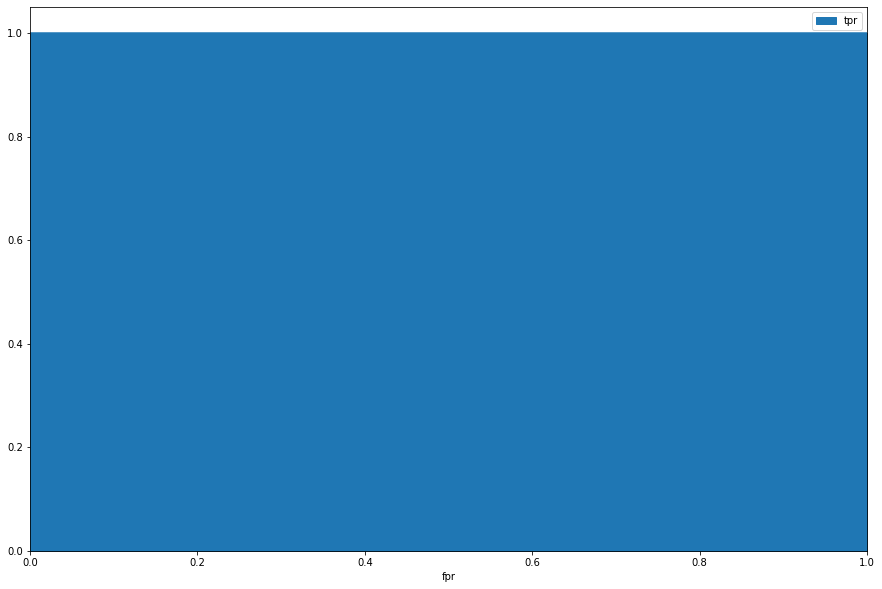

In [54]:
prescience.plot_roc_curve(model_id)

## Request your own predictions
You can then test the prediction model by filling properties by yourself, and see the result :

In [55]:
def make_prediction(sepal_width, sepal_length, petal_width, petal_length):
    payload = model.get_model_evaluation_payload(arguments={
        'sepal_length': sepal_length,
        'sepal_width': sepal_width,
        'petal_length': petal_length,
        'petal_width': petal_width
    })
    result = payload.evaluate()
    result.show()
    print(json.dumps(result.json_dict['result'], indent=4))

In [56]:
FEATURES = ['sepal_width', 'sepal_length', 'petal_width', 'petal_length']

sepal_width_widget = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=10.0,
    step=0.1,
    description='Sepal Width:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
sepal_length_widget = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=10.0,
    step=0.1,
    description='Sepal Length:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
petal_width_widget = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=10.0,
    step=0.1,
    description='Petal Width:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
petal_length_widget = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=10.0,
    step=0.1,
    description='Petal Length:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

ui = widgets.HBox([sepal_width_widget, sepal_length_widget, petal_width_widget, petal_length_widget], layout=widgets.Layout(width='100%'))
out = widgets.interactive_output(make_prediction, {
    'sepal_width': sepal_width_widget,
    'sepal_length': sepal_length_widget,
    'petal_width': petal_width_widget,
    'petal_length': petal_length_widget
})
display(ui, out)

Output()

## Under the hood

As already told before, an auto-ml tasks start from a source object and creates 2 other objects, first a dataset and then a model. You can see the relationship between each other by doing so : 

In [57]:
source.tree().show()

Source(iris)
 +-- Dataset(iris_dataset_2gN4jNj)
     +-- Model(iris_model_2gN4jNj)


### The Source object

The source object is almost like your original data, except that it holds some metadata inside that have been computed during the parse tasks. We wont describe all the metadata here but this is several statistics like :
* The standard deviation for each column
* The type of data contained in the column (integer, boolean, text, etc...)
* If the column can contains `null` values
* etc...

You can see the computed statistic on your source by doing so :

In [58]:
source.schema().show('html')

,name,type,nullable,n_cat,ratio,n_pop,median,mode,positive
0,sepal_length,double,True,0,None,None,5.8,None,True
1,sepal_width,double,True,0,None,None,3.0,None,True
2,petal_length,double,True,0,None,None,4.3,None,True
3,petal_width,double,True,0,None,None,1.3,None,True
4,label,string,True,3,None,None,0.0,Iris-virginica,True


You can even plot your source object if you want to visually see your timeserie. For doing so you will just need to indicate the name of the column used as `x` and the name if the column used as 'y'.

In [59]:
def plot_source(x, y):
    source.plot(x=x, y=y, clss=LABEL_COLUMN)

In [60]:
import ipywidgets as widgets

FEATURES = ['sepal_width', 'sepal_length', 'petal_width', 'petal_length']

x_axe = widgets.Dropdown(
    options=FEATURES,
    value=FEATURES[0],
    description='X axe :',
    disabled=False,
)
y_axe = widgets.Dropdown(
    options=FEATURES,
    value=FEATURES[-1],
    description='Y axe :',
    disabled=False,
)

ui = widgets.HBox([x_axe, y_axe], layout=widgets.Layout(width='100%'))
out = widgets.interactive_output(plot_source, {'x': x_axe, 'y': y_axe})
display(ui, out)

Output()

### The dataset object

The `dataset` object contains the same data than in your `source` except that :

* Your source data has been split into `n` subsets that we call `fold`.
* Each fold contains a `train` part and a `test` part. Machine Learning algorithm will train only on the `train` part and they will be evaluated on the `test` part. It is a standard process in machine learning in order to evaluate relevancy of machine learning algorithms on data that they have never seen before.
* The data (and columns name) has been transformed so that it can be understandable by machine learning algorithms (exemple : standardization). The rules of transformation won't be described here but all you have to know is that previously computed statistics are used to choose the good transformation strategy.

Example when showing the first 10 lines of the first fold :

In [61]:
df = prescience.fold_dataframe(dataset_id=dataset_id, fold_number=0, test_part=False)
HTML(df.head(10).to_html())

Directory '/tmp/.prescience/cache/datasets/iris_dataset_2gN4jNj/fold/0/train' doesn't exists. Creating it...
Updating cache for source 'iris_dataset_2gN4jNj' : /tmp/.prescience/cache/datasets/iris_dataset_2gN4jNj/fold/0/train


,label,scaled_imputed_sepal_width,scaled_imputed_petal_width,scaled_imputed_petal_length,scaled_imputed_sepal_length
0,Iris-setosa,0.819195,-1.313267,-1.286814,-1.011918
1,Iris-setosa,-0.123566,-1.444213,-1.514256,-1.858559
2,Iris-setosa,1.054885,-1.313267,-1.286814,-0.770021
3,Iris-setosa,0.819195,-1.313267,-1.343674,-0.770021
4,Iris-setosa,0.112124,-1.313267,-1.229953,-1.253816
5,Iris-setosa,0.347815,-1.313267,-1.457395,-1.011918
6,Iris-setosa,1.054885,-1.182322,-1.400535,-1.011918
7,Iris-versicolor,-1.537707,-0.265705,-0.263325,-1.132867
8,Iris-versicolor,-0.594946,0.127131,0.134699,0.318518
9,Iris-versicolor,-0.123566,0.650913,0.703304,1.044210


You can plot each fold of the dataset to see the difference with the source :

In [62]:
def plot_fold(train_test, fold_number, x, y):
    prescience.plot_dataset(
        dataset_id=dataset_id,
        plot_train=(train_test=='train'),
        plot_test=(train_test=='test'),
        fold_number=fold_number,
        x=x,
        y=y,
        clss=LABEL_COLUMN
    )

In [68]:
FEATURES_SCALED = ['scaled_imputed_sepal_width', 'scaled_imputed_petal_width', 'scaled_imputed_petal_length', 'scaled_imputed_sepal_length']
TRAIN_TEST = ['train', 'test']
FOLDS = [x for x in range(0, 3)]

train_test = widgets.Dropdown(
    options=TRAIN_TEST,
    value=TRAIN_TEST[0],
    description='Part',
    disabled=False,
)
fold_number = widgets.Dropdown(
    options=FOLDS,
    value=FOLDS[0],
    description='Fold number',
    disabled=False,
)
x_axe_scaled = widgets.Dropdown(
    options=FEATURES_SCALED,
    value=FEATURES_SCALED[0],
    description='X axe :',
    disabled=False,
)
y_axe_scaled = widgets.Dropdown(
    options=FEATURES_SCALED,
    value=FEATURES_SCALED[-1],
    description='Y axe :',
    disabled=False,
)

ui = widgets.HBox([train_test, fold_number, x_axe_scaled, y_axe_scaled], layout=widgets.Layout(width='100%'))
out = widgets.interactive_output(plot_fold, {'train_test': train_test, 'fold_number': fold_number, 'x': x_axe_scaled, 'y': y_axe_scaled})
display(ui, out)

Output()

### The model object

The `model` object is created from a `dataset` with a `train task` however a train task needs to be launched on a specific machine learning algorithm with defined parameters. That's why there is an intermediate task which is called the `optimization task`.

The aim of an optimization task is to use the previously created folds of our dataset to train a lot of machine learning algorithms with different hyperparameters, evaluate them and find the best.

All results of evaluations are stored in prescience into objects called `evaluations results`. You can request the visualisation of previously computed evaluation by doing so :

In [64]:
evaluation_results = prescience.get_evaluation_results(
    dataset_id,
    # Sort all the results by the selected scoring metric
    sort_column=f'costs.{SCORING_METRIC}'
)
evaluation_results.show('html')

,uuid,status,config_name,past_steps,horizon,discount,accuracy_cost,cohen_kappa_cost,f1_micro_cost,f1_macro_cost,roc_auc_micro_cost,roc_auc_macro_cost,average_precision_micro_cost,average_precision_macro_cost
0,b3f7f3cc-e439-457c-a9dd-f6fc2adac565,BUILT,skgradientboostingclassifier,-,-,-,0.005,0.007,0.005,0.005,0.005,0.005,0.012,0.009
1,bebe5daf-1904-4b29-bf7c-6e57e16bfc0e,BUILT,xgboostclassifier,-,-,-,0.005,0.007,0.005,0.005,0.006,0.007,0.014,0.010
2,1a1a700e-bd3c-4d74-939a-84827b5eece0,BUILT,sklogisticregressionclassifier,-,-,-,0.029,0.044,0.029,0.029,0.001,0.001,0.001,0.001
3,6f647639-82d9-45f9-9f3e-facc9c3c1320,BUILT,xgboostclassifier,-,-,-,0.054,0.081,0.054,0.052,0.005,0.011,0.014,0.031
4,8bb43aa4-be13-4e7b-b707-62123bce2432,BUILT,skgradientboostingclassifier,-,-,-,0.122,0.183,0.122,0.125,0.014,0.007,0.026,0.013
5,052d2229-8b35-4995-a4d6-149f9b64af77,BUILT,skgradientboostingclassifier,-,-,-,0.196,0.296,0.196,0.204,0.059,0.073,0.122,0.148
6,5bfcaaa8-6286-4a8e-a854-a63ebcb3685b,BUILT,xgboostclassifier,-,-,-,0.689,1.000,0.689,0.842,0.500,0.500,0.667,0.667
7,2cb19b40-7521-41a1-ab33-ef691949936a,BUILT,xgboostclassifier,-,-,-,0.689,1.000,0.689,0.842,0.510,0.500,0.673,0.667


You can see the evolution of optimization and evaluation results over time by ploting it :

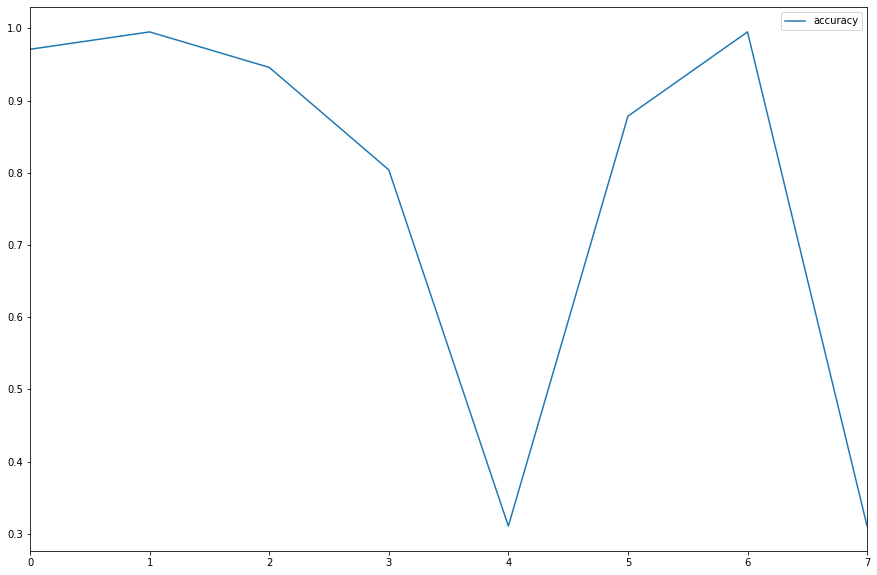

In [65]:
prescience.plot_evaluations(
    dataset_id=dataset_id,
    scoring_metric=SCORING_METRIC
)

The first row of the table is the best model and configuration find. If we compare this configuration with the configuration of the model deployed we will see that they are the same.

In [66]:
# Show the config from the best evaluation results
config_eval = evaluation_results.content[0].config()
import json
print(json.dumps(config_eval.json_dict, indent=4))

{
    "name": "skgradientboostingclassifier",
    "display_name": "Gradient Boosting",
    "class_identifier": "ensemble.GradientBoostingClassifier",
    "fit_dimension": 0,
    "backend": "sklearn",
    "multioutput": true,
    "kwargs": {
        "loss": "deviance",
        "criterion": "friedman_mse",
        "max_depth": 5,
        "subsample": 0.6914557913451629,
        "max_features": 0.4404447681090091,
        "n_estimators": 475,
        "learning_rate": 0.13535618815078243,
        "max_leaf_nodes": "None",
        "min_samples_leaf": 42,
        "min_samples_split": 80,
        "min_impurity_decrease": 0,
        "min_weight_fraction_leaf": 0.02219003934054642
    }
}


In [67]:
# Show the config from the trained model
config_train = model.config()
print(json.dumps(config_train.json_dict, indent=4))

{
    "name": "xgboostclassifier",
    "display_name": "XGBoost Classifier",
    "class_identifier": "xgboost.sklearn.XGBClassifier",
    "fit_dimension": 0,
    "backend": "xgboost",
    "multioutput": false,
    "kwargs": {
        "gamma": 0.0,
        "n_jobs": -1,
        "booster": "gbtree",
        "max_depth": 6,
        "objective": "multi:softprob",
        "reg_alpha": 0.01,
        "subsample": 1.0,
        "reg_lambda": 1.0,
        "n_estimators": 50,
        "learning_rate": 0.3,
        "max_delta_step": 0,
        "colsample_bytree": 1.0,
        "min_child_weight": 1.0,
        "scale_pos_weight": 1.0,
        "colsample_bylevel": 1.0
    }
}
